In [39]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [40]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [41]:
df = pd.read_csv('/content/fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,...,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,72,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,120,108,0,0,4,6,11,...,243,255,255,251,242,236,230,246,228,0,0,3,0,2,0,0,210,228,228,233,0,0,0,0,0,0,0,0,0,31,81,133,184,201,190,117,0,0,2,1,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,43,117,34,15,24,33,117,80,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,51,144,152,202,213,210,205,204,221,157,172,131,55,...,0,77,157,148,155,146,151,149,152,154,157,158,161,148,159,58,0,6,0,0,0,0,0,0,0,0,0,4,0,60,143,143,148,146,152,152,148,148,147,145,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,0,0,0,2,0,33,114,37,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,47,136,31,136,42,0,3,0,...,138,152,160,152,162,144,208,181,1,18,11,17,13,13,11,10,7,5,5,5,7,0,0,0,1,0,0,41,69,88,86,94,106,114,118,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,0,2,0,58,145,114,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,29,132,0,0,101,10,0,2,0,0,...,155,178,149,163,165,138,147,170,149,134,165,153,155,134,143,172,215,62,0,0,0,0,0,0,0,0,10,190,178,194,209,211,209,205,211,215,213,217,225,228,213,203,174,151,188,10,0,0,0,0


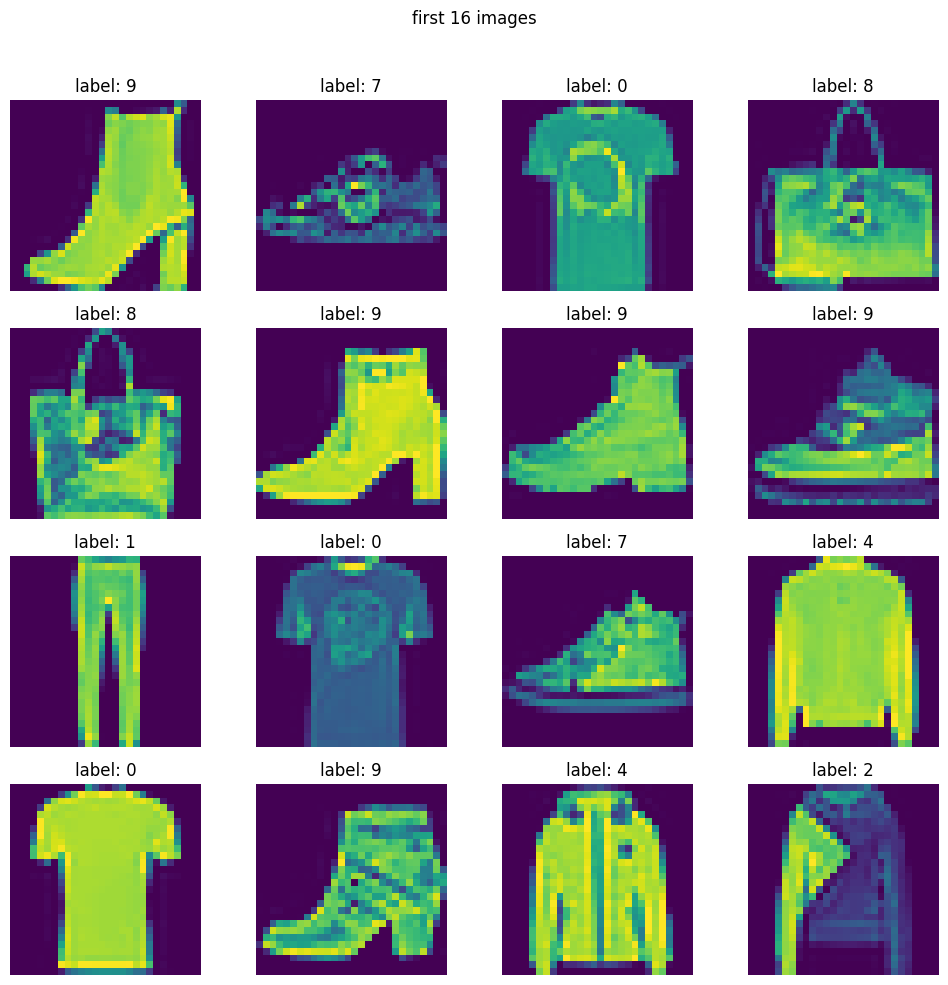

In [42]:
fig, axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle('first 16 images')

# plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img = df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f'label: {df.iloc[i, 0]}')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [43]:
# train test split
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# scale the feature
X_train = X_train / 255.0
X_test = X_test / 255.0

In [45]:
# create custom dataset class
class customdataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [46]:
train_data = customdataset(X_train, y_train)
test_data = customdataset(X_test, y_test)

In [47]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [48]:
class MyNN(nn.Module):

  def __init__(self, input_size):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(input_size, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )

  def forward(self, X):
    return self.model(X)

In [49]:
learning_rate = 0.01
epochs = 100

In [50]:
model = MyNN(X_train.shape[1])

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    y_pred = model(batch_features)

    loss = criterion(y_pred, batch_labels)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    total_epoch_loss += loss.item()

  print(f'epoch: {epoch+1}, loss: {total_epoch_loss/len(train_loader)}')

epoch: 1, loss: 0.8783851951360703
epoch: 2, loss: 0.6324065214395523
epoch: 3, loss: 0.5315540619691212
epoch: 4, loss: 0.5186848501364391
epoch: 5, loss: 0.4635705310602983
epoch: 6, loss: 0.4539120938380559
epoch: 7, loss: 0.4075775976975759
epoch: 8, loss: 0.4115352872014046
epoch: 9, loss: 0.37464396784702936
epoch: 10, loss: 0.36041767537593844
epoch: 11, loss: 0.3548834595580896
epoch: 12, loss: 0.3319347141186396
epoch: 13, loss: 0.34368347908059754
epoch: 14, loss: 0.3364310719072819
epoch: 15, loss: 0.35402343983451523
epoch: 16, loss: 0.3196510047465563
epoch: 17, loss: 0.2947200993448496
epoch: 18, loss: 0.29638122849166393
epoch: 19, loss: 0.2760750410084923
epoch: 20, loss: 0.255799074669679
epoch: 21, loss: 0.2956438385198514
epoch: 22, loss: 0.28410488728433847
epoch: 23, loss: 0.27481596810122333
epoch: 24, loss: 0.24912413978328307
epoch: 25, loss: 0.22622781085471314
epoch: 26, loss: 0.2405648647993803
epoch: 27, loss: 0.23707283968726794
epoch: 28, loss: 0.226854089

In [52]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [53]:
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in test_loader:
    y_pred = model(batch_features)
    _, predicted = torch.max(y_pred.data, 1)
    total += batch_labels.size(0)
    correct += (predicted == batch_labels).sum().item()

print(correct/total)

0.8291666666666667


In [54]:
from sklearn.metrics import accuracy_score, classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f'Accuracy: {accuracy_score(all_labels, all_preds)}')
print(classification_report(all_labels, all_preds))

Accuracy: 0.8291666666666667
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       146
           1       0.96      0.95      0.95       122
           2       0.79      0.77      0.78       119
           3       0.84      0.77      0.80       126
           4       0.71      0.80      0.75       137
           5       0.96      0.86      0.91       113
           6       0.59      0.70      0.64       128
           7       0.92      0.95      0.93       111
           8       0.97      0.95      0.96       111
           9       0.88      0.98      0.92        87

    accuracy                           0.83      1200
   macro avg       0.84      0.84      0.84      1200
weighted avg       0.84      0.83      0.83      1200



In [55]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

class MyNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, X):
        return self.model(X)

# Initialize model, loss, optimizer
model = MyNN(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Lists to store metrics
train_losses = []
train_accuracies = []
val_accuracies = []

# Assuming you have validation data (modify as needed)
# val_loader = DataLoader(...)  # Your validation DataLoader

for epoch in range(100):
    # Training phase
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch_features, batch_labels in train_loader:
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training metrics
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += batch_labels.size(0)
        correct_train += (predicted == batch_labels).sum().item()

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_features, val_labels in val_loader:
            val_outputs = model(val_features)
            _, val_predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()

    # Store metrics
    train_loss = epoch_train_loss/len(train_loader)
    train_acc = 100 * correct_train / total_train
    val_acc = 100 * correct_val / total_val

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1:03d}: '
          f'Train Loss: {train_loss:.4f} | '
          f'Train Acc: {train_acc:.2f}% | '
          f'Val Acc: {val_acc:.2f}%')

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.legend()
plt.show()

NameError: name 'val_loader' is not defined

<ipython-input-61-3ac158fa6bda>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
<ipython-input-61-3ac158fa6bda>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).long()


Epoch 1: Train Loss: 0.7574 | Val Loss: 0.6108 | Train Acc: 72.25% | Val Acc: 75.75%
Epoch 2: Train Loss: 0.5782 | Val Loss: 0.5596 | Train Acc: 78.60% | Val Acc: 79.75%
Epoch 3: Train Loss: 0.5005 | Val Loss: 0.5231 | Train Acc: 81.35% | Val Acc: 81.50%
Epoch 4: Train Loss: 0.4690 | Val Loss: 0.5522 | Train Acc: 82.96% | Val Acc: 80.83%
Epoch 5: Train Loss: 0.4237 | Val Loss: 0.5212 | Train Acc: 84.25% | Val Acc: 81.25%
Epoch 6: Train Loss: 0.3944 | Val Loss: 0.5375 | Train Acc: 85.60% | Val Acc: 80.50%
Epoch 7: Train Loss: 0.3995 | Val Loss: 0.5744 | Train Acc: 85.02% | Val Acc: 79.50%
Epoch 8: Train Loss: 0.3791 | Val Loss: 0.6080 | Train Acc: 85.71% | Val Acc: 77.92%
Epoch 9: Train Loss: 0.3649 | Val Loss: 0.6030 | Train Acc: 86.31% | Val Acc: 78.33%
Epoch 10: Train Loss: 0.3417 | Val Loss: 0.5777 | Train Acc: 87.67% | Val Acc: 79.67%
Epoch 11: Train Loss: 0.3532 | Val Loss: 0.6395 | Train Acc: 86.79% | Val Acc: 80.25%
Epoch 12: Train Loss: 0.3410 | Val Loss: 0.5404 | Train Acc: 87

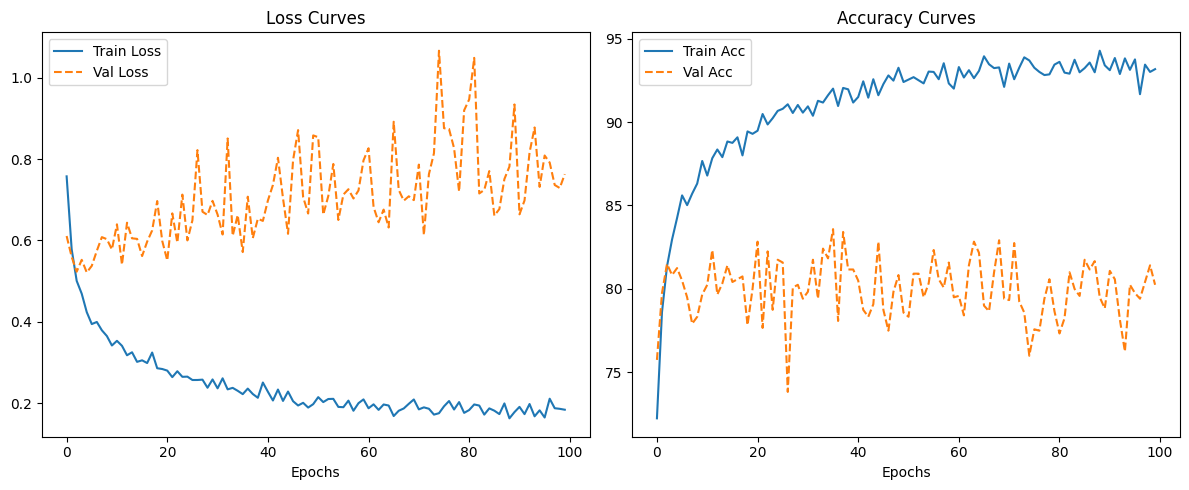

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# 1. Prepare Data (example - replace with your data)
# Assuming you have:
# X_train, y_train (training data)
# X_val, y_val (validation data)

# Convert to tensors if needed
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).long()
X_val = torch.tensor(X_test).float()
y_val = torch.tensor(y_test).long()

# 2. Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # Correct definition

# 3. Model definition (keep your existing MyNN class)
class MyNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.Dropout(p=0.3),
            nn.Linear(64, 10)
        )

    def forward(self, X):
        return self.model(X)

# 4. Training loop with validation
model = MyNN(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []
train_accuracies = []
val_accuracies = []
val_losses = []  # New list for validation loss

for epoch in range(100):
    # Training phase
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch_features, batch_labels in train_loader:
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training metrics
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += batch_labels.size(0)
        correct_train += (predicted == batch_labels).sum().item()

    # Validation phase (now using properly defined val_loader)
    model.eval()
    correct_val = 0
    total_val = 0
    epoch_val_loss = 0  # Track validation loss

    with torch.no_grad():
        for val_features, val_labels in val_loader:  # Now works
            val_outputs = model(val_features)

             # Calculate validation loss
            val_loss = criterion(val_outputs, val_labels)
            epoch_val_loss += val_loss.item()

            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()


        # Store metrics
    train_loss = epoch_train_loss/len(train_loader)
    train_acc = 100 * correct_train / total_train
    val_acc = 100 * correct_val / total_val
    val_loss = epoch_val_loss / len(val_loader)  # Average validation loss

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)  # Store validation loss

    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '  # Added validation loss
          f'Train Acc: {train_acc:.2f}% | '
          f'Val Acc: {val_acc:.2f}%')


# 7. Plotting
print("\n\n")
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss', linestyle='--')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc', linestyle='--')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()